# Exploring And Forecasting Crime Rates In NYC

---------------------
## Introduction
---------------------
This post is about the project I completed at [Insight Data Science](http://insightdatascience.com/).  The goal of the project was to develop a data driven strategy for reducing crime in New York City using historical data provided by the [NYC Open Data Website](https://nycopendata.socrata.com/). Analyzing the crime data it became evident that different types of crimes affect different neighborhoods at different times of the year.  I believe that by developing a predictive model of monthly crime rates on the neighborhood level, police will be able to distribute their resources to the right neigborhoods at the appropriate time and hopefully this will lead to a reduction in the crime rates.  This led me to create a web application, [CrimeTime](https://crimetime.online), where users can preform similar analysis in their neighborhood anywhere in New York City. 

The purpose of this post is therefore two-fold:

1. Discuss the analysis of the historical crime data as well as the predictive models to forecast crime rates in the future.
2. Show how to use the tools I developed; this will be helpful to those trying to extend the codebase of <a href="https://crimetime.online">CrimeTime.online</a>

### Analysis and modeling
In this post I will be covering a few topics that involve learning from data and developing a predictive model for crime rates.  Specifically I will,

- Perform exploratory analysis on temporal and geospatial crime data to find where and when specific crimes happen the most.

We will see that different crimes affect different areas in the Manhattan and that monthly crime rates peak at different points of the year depending on the type of crime. We then,

- Develop a time series model that uses historical data to predict monthly number of crimes in two neighborhoods that have the highest crime rates in Manhattan.

Once we can predict future montly crime rates on a neighborhood level, police can distribute their resources to the right neigborhoods at the most appropriate time. 


### About the web application 
Throughout this post I'll be using the classes and methods I developed in the web application [CrimeTime](https://crimetime.online).  Taking an object oriented approach was useful because I have the flexibility of extending the code easily and also using it in a different environment like this post.  The web application I built was written in <a href="https://www.python.org/"> Python</a> and  <a href="http://flask.pocoo.org/"> Flask</a>
and was deployed to <a href="https://aws.amazon.com/"> Amazon web services.</a>  Users are prompted to enter an address and then
I use the <a href="https://pypi.python.org/pypi/geopy">geopy</a> library to get
the latitude and longitude of the address.  Once that latitude and
longitude are known I 
use the <a href="https://pypi.python.org/pypi/Shapely">shapely</a> library to find out which police precinct the address is in and obtain the data on that police precinct.


The info for police precincts was obtained by scraping the NYPD's <a href="http://www.nyc.gov/html/nypd/html/home/precincts.shtml"> website </a> using <a href="https://pypi.python.org/pypi/beautifulsoup4"> beautifulsoup</a> library and also this specific <a href="https://nycopendata.socrata.com/Public-Safety/Police-Precincts/78dh-3ptz/data">database</a> on the NYC Open Data Website.
The crime data was obtained from the <a href="https://nycopendata.socrata.com/">NYC Open Data Website</a> and cleaning was completed using <a href="http://pandas.pydata.org/">Pandas</a> and <a href="http://geopandas.org/">GeoPandas</a>. The data was then stored in a <a href="https://sqlite.org/">SQLite</a> database. Forecasted crime rates were predicted using a <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">seasonal ARIMA</a> model through the python
library <a href="http://statsmodels.sourceforge.net/"> StatsModels</a>. I used a grid search to obtain the appropriate model paramaters that minimize the validation error.

The source code for this project can be found <a href="https://github.com/mdh266/CrimeTime">here</a> and along with instructions on how to build a local copy of the <a href="http://www.sphinx-doc.org/en/stable/">Sphinx</a> based documentation.

---------------------
## Exploratory Data Analysis
---------------------
After downloading the crime data (in CSV format) from the [NYC Open Data Website](https://nycopendata.socrata.com/) and cleaning I decided to store it in a sqlite database.  I put all these steps into a method in the <code>PreProcessor</code> class from CrimeTime (in the backend directory).  If one wants to run the application on their local machine, all you have to do is pass the <code>PreProcessor</code> object the address and name the database we want to make during instantiation:

In [17]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../backend/")

In [3]:
from PreProcessor import PreProcessor 

Instantiate the preprocessor object with location and name of database
PP = PreProcessor("../data/CrimeTime.db")

The actual CSV file should be located in the same directory ("<code>/data/</code>").  We can clean this file and create the database called "<code>CrimeTime.db</code>" with the crime data stored in a table called "<code>NYC_Crime</code>" by the following command:

In [2]:
PP.make_NYC_Crime_database("NYC_Crime")

The preprocessor object can also scrape the NYPD's
<a href="http://www.nyc.gov/html/nypd/html/home/precincts.shtml">website  </a> and obtain the address and telephone number of each precinct police station and store it in the "<code>CrimeTime.db</code>" database as the table "<code>NYC_CRIME</code>." This done through the command:

In [3]:
PP.make_NYC_precinct_database()

**Note: If NYC Open Data no longer provides the crime data email me and I can send you the database. You will no longer need to do the above commands to make the database then.**

Now that our data is cleaned we can access the it very easily using [sqlite3](https://docs.python.org/2/library/sqlite3.html) database library and read it into a [pandas](http://pandas.pydata.org/) dataframe.  We obtain all the crime data on Manhattan by the commands:

In [3]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('../data/CrimeTime.db')

# SQL Command
sql_command = 'SELECT * FROM NYC_Crime WHERE BOROUGH = \'MANHATTAN\''

# Now querry the database using the above command
crime_df = pd.read_sql(sql_command, conn)

# close the connection to the database
conn.close()

You'll notice I only have data that from 2006 to 2015. The data for 2016 was not available at the time and the data before 2006 is rather sparse so I decided to neglect it. Let's get a look at how crime in Manhattan has evolved over the last 10 years.  


We will plot the yearly crime data, but first we must group all the crimes by their year, we do this with Pandas the command:

In [4]:
CRIMES_PER_YEAR = crime_df.groupby('YEAR').size()

This creates an Pandas series, where the index is the year and the values are the number of crimes that occured in that year. We can plot this yearly data directly using the <code>.plot()</code> method on the dataframe.  This calls matplotlib library under the hood:

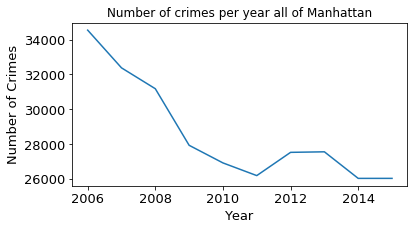

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(6, 3))

CRIMES_PER_YEAR.plot(title='Number of crimes per year all of Manhattan',
                     fontsize=13)

plt.xlabel('Year',fontsize=13)
plt.ylabel('Number of Crimes',fontsize=13)
plt.ticklabel_format(useOffset=False)

One thing to notice is that crime in the last 10 years has been going down!

Let's just look at the crime date for larceny and assault.  We can build new dataframes just for these specific crimes with the commands: 

In [6]:
LARCENY = crime_df[crime_df.OFFENSE == 'GRAND LARCENY']
ASSAULT = crime_df[crime_df.OFFENSE == 'FELONY ASSAULT']

In order to visualize the geospatial distribution of crimes in Manhattan, lets break down our data in to the number of crimes per month (in 2015) that occrur within a precinct. We can do this in pandas using the <code>groupby</code> command:

In [7]:
CRIMES_2015 = ASSAULT[ASSAULT.YEAR == 2015]
CRIMES_2015 = CRIMES_2015.groupby('PRECINCT').size()

Now that we have the number of crimes per precinct and the precinct geometries (Note: I downloaded them as a <a href="https://nycopendata.socrata.com/Public-Safety/Police-Precincts/78dh-3ptz/data">geojson file</a> and edited out non-Manhattan police precincts by hand.) we can visualize the number of assaults per precint using <a href="https://pypi.python.org/pypi/folium">Folium</a>. Folium is python package that has very nice geospatial visualization cabilities. Using it we can directly read in the geojson file and then plot the number of crimes that occur each month in a precinct using the choropleth function. Let's visualize the number the assaults in 2015:

In [8]:
import folium

# Central lat/long values of NYC
nyc_coor = [40.81,-73.9999]

# instatiate a folium map object with the above coordinate at center
nyc_crime_map = folium.Map(location=nyc_coor,zoom_start=11)

# the path to the geojson file of the manhattan precincts
pathgeo = './manhattan_precincts.geojson'

# make the chorlopleth map
nyc_crime_map.choropleth(geo_data=pathgeo,
                        data=CRIMES_2015,
                        key_on='feature.properties.Precinct',
                        fill_color='BuPu', 
                        fill_opacity=0.7, 
                        line_opacity=0.2,
                        legend_name='MANHATTAN')
# show the map
nyc_crime_map

/Users/mukeharmon/miniconda/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can look at the other crimes if we want too, and for the purposes of this blog well just look at larceny:

In [9]:
CRIMES_2015 = LARCENY[LARCENY.YEAR == 2015]
CRIMES_2015 = CRIMES_2015.groupby('PRECINCT').size()

# instantiate the object
nyc_crime_map = folium.Map(location=nyc_coor,zoom_start=11)

# path to geojson precinct file
pathgeo = './manhattan_precincts.geojson'

# make the map
nyc_crime_map.choropleth(geo_data=pathgeo,
                        data=CRIMES_2015,
                        key_on='feature.properties.Precinct',
                        fill_color='BuPu',
                        fill_opacity=0.7,
                        line_opacity=0.2,
                        legend_name='MANHATTAN')
# show the map
nyc_crime_map

We can see that larceny seems to be highest in midtown while assault seems to be highest in East Harlem.  We'll focus in on these two neighborhoods and analyze larceny in Midtown and assaults in East Harlem to see what we can learn from the historical data to help us predict crimes in the future.  Once we are able to predict crime rates in different parts of the city, police might be able to redistribute their resources at the appropriate place and time of the year.

We'll be using the "<code>CrimeMapper</code>" class from CrimeTime (in the backend directory) to house our data and make our graphics.

In [18]:
from CrimeMapper import CrimeMapper

Now we instantiate the <code>CrimeMapper</code> object with the boolean False to declare that we are not in prpoduction mode (production mode is run through the Flask app).  We can then find the precinct for our address using the <code>find_precinct(address)</code> method:

In [19]:
EastHarlem = CrimeMapper(production_mode=False)
EastHarlem.find_precinct("162 E 102nd St, Manhattan, NY")

We can now get all the crime data for this precinct and the following crimes:
- Assault
- Larceny
- Robbery
- Burglary
- Car Theft

We find the crime data for assault for just our precinct and store it in a pandas dataframe titled <code>crime_df</code> in the <code>CrimeMapper</code> object:

In [20]:
EastHarlem.get_crime_data("Assault")
EastHarlem.crime_df.head()

,DATE,WEEKDAY,MONTH,DAY,YEAR,HOUR,OFFENSE,PRECINCT,BOROUGH,LATITUDE,LONGITUDE
0,01/09/2006 01:50:00 AM,Monday,Jan,9.0,2006,1.0,FELONY ASSAULT,23,MANHATTAN,40.791261,-73.947968
1,01/09/2006 06:26:00 PM,Monday,Jan,9.0,2006,18.0,FELONY ASSAULT,23,MANHATTAN,40.795695,-73.938737
2,01/10/2006 03:30:00 PM,Tuesday,Jan,10.0,2006,15.0,FELONY ASSAULT,23,MANHATTAN,40.793842,-73.944070
3,02/11/2006 01:45:00 AM,Saturday,Feb,11.0,2006,1.0,FELONY ASSAULT,23,MANHATTAN,40.789959,-73.945857
4,02/11/2006 02:20:00 AM,Saturday,Feb,11.0,2006,2.0,FELONY ASSAULT,23,MANHATTAN,40.797300,-73.948928


The dataframe <code>crime_df</code> is just the raw daily assault data, we can turn it into a time series, where we record the monthly number of assaults in this precinct by using the <code>make_time_series()</code> command.  The time series 

In [21]:
EastHarlem.make_time_series()
EastHarlem.ts.head()

,Crimes
Date,
2006-01-31,18
2006-02-28,11
2006-03-31,13
2006-04-30,11
2006-05-31,15


*Note: We actually still store this time series as a Pandas dataframe instead of a Pandas timeseries.*

We can now decompose our time series data into its trend and season using the <code>plot_decompose()</code> function.  Under the hood of the <code>CrimeMapper</code> class this calls the statsmodels <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html">"seasonal_decompose()"</a> method with a frequency of 12 a yearly frequency.

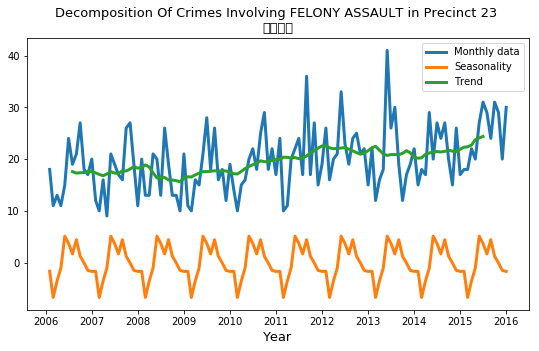

In [23]:
EastHarlem.plot_decompose()

The trend of monthly assaults in East Harlem has been steadly rising around 4% - 5% each year on average, but shot up to around a 10% increase last year.  The seasonality tells us about when assaults are at the highest and lowest in the year.  We can see that assaults in East Harlem peak in the summer time and are at their lowest in the beginning of the year.  This makes sense since it is the time of year when people are the most and the least likely to be outside respectively.  


Let's repeat the same process for Midtown:

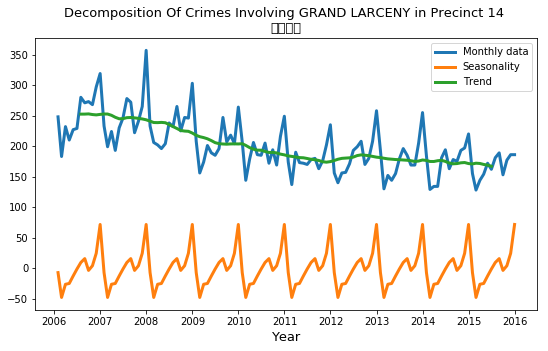

In [24]:
# Instantiate the Midtown CrimeMapper object
Midtown = CrimeMapper(production_mode=False)

# Find the Midtown south precinct
Midtown.find_precinct("357 West 35th Street, New York, NY")

# Get the crime data for Larceny in this precinct
Midtown.get_crime_data("Larceny")

# Make the data into a time series
Midtown.make_time_series()

# Decompose the time series into trend and seasonality and plot it
Midtown.plot_decompose()

We can see that overall the number of crimes involving larceny has been steadily decreasing over the years. We can also see that larceny in Midtown is very seasonal. Larceny is lowest at the beginning of the year and highest at the end of year. Sadly this makes some sense, since larceny involves shoplifting, many people might be stealing presents for the holidays.


Since the two crimes in the two neighborhoods are out of phase with one another (occur at different times of the year), it may be possible to redirect police efforts to the different areas depending on the time of year. Let's develop a predictive model to estimate the number of monthly crimes involving grand larceny in Midtown and the number of assaults in East Harlem using the time series data. Being able to predict the number of incidents on a month-to-month basis would be useful for police as they might be able to better prepare for increases and decreases in crime within the city and reallocate resources to specific neighborhoods at the appropriate time of year.

---------------------------------
## TIME SERIES ANALYSIS
---------------------------------
There are lot of great resource for time series analysis.  For this project I used the following blogs:

[A tutorial on time series model](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/) is a good place to start, but its in R, so I turned to, [Time series forecasting in python](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) to learn how to do time series analysis in Python.  Another good resource is [Tom Augspurger's blog](http://tomaugspurger.github.io/modern-7-timeseries). Finally, for seasonal ARIMA I found the the following blog [post](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) very helpful.

I won't go over the details of modeling with ARIMA, but more information can be found in the links above.  It's worth noting that R has a lot better time series capabilities than Python. However, one can use the [statsmodels library](http://statsmodels.sourceforge.net/) to perform ARIMA modeling.

### ARIMA: Autoregressive Integrated Moving Average

ARIMA is a standard techinque for modeling and forecasting in time series analysis.  The general model for a stationary process is given by formula, 

\begin{equation}
C_{T} = \mu +  \sum_{i=1}^{p} \gamma_{i} C_{T-i} +\sum_{i=0}^{q} \theta_{i} \epsilon_{T-i}.
\end{equation}

Where $C_{T}$ is related to the number of crimes that occured in month $T$ and $\epsilon_{T}$ is a normally distributed random error.  We can see that ARIMA incorporates trying to balance a linear combination of previous months number of crimes as well as a linear combination of this month's and previous months' random errors.  An ARIMA model, ARIMA($p,d,q$), has three paramaters, $p,d,$ and $q$.  $p$ and $q$ correspond to the maximum number previous months' crimes and random errors we incorporate into or model. The number $d$ corresponds to the number of differences in the monlthy number of crimes we have to take before our data is stationary.

### Seasonal ARIMA

Seasonal ARIMA is a little more complicated than the standard ARIMA model. Seasonal ARIMA takes into effect the seasonality of the data and tries to fit an appropriate model labeled SARIMA$(P,D,Q)_{m}$ where $m$ is the seasonality and in our case will turn out to be 12, since it is yearly.  The seasonal ARIMA model will therefore have 7 paramaters: $(p,d,q)$ for the non-seasonal component of the model and $(P,D,Q)_{m}$ for the seasonal component of the model.

The seasonal ARIMA class which I wrote, <code>Seasonal_Arima</code>, uses the <a href="The seasonal ARIMA class uses the SARIMAX model from StatsModels.">SARIMAX model</a> from the <a href="http://www.statsmodels.org/stable/index.html">StatsModels library</a>. We import the <code>Seasonal_ARIMA</code> class from the Forecasting file (in the backend directory):

In [25]:
from Forecasting import Seasonal_ARIMA



We preform some preliminary analysis on the assault data using the <a href="http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html">Dicky-Fuller test</a> in StatsModels.  The Dicky-Fuller test is a test for stationarity in time series data.  Stationarity means that our time series data has constant mean and constant variance.

Our analysis involves looking at differences and testing to see if the differences transform the data to being stationary. We first instantiate a model on the time series data for East Harlem and then use the Dickey-Fuller test to see if the first difference and seasonal first difference are stationary:


First Difference:



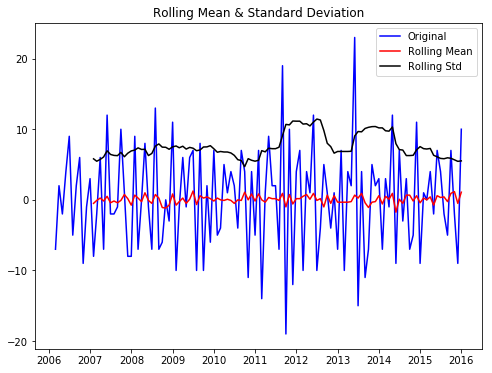

Results of Dickey-Fuller Test:
Test Statistic                -7.662762e+00
p-value                        1.671661e-11
#Lags Used                     1.100000e+01
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64

Seasonal First Difference:



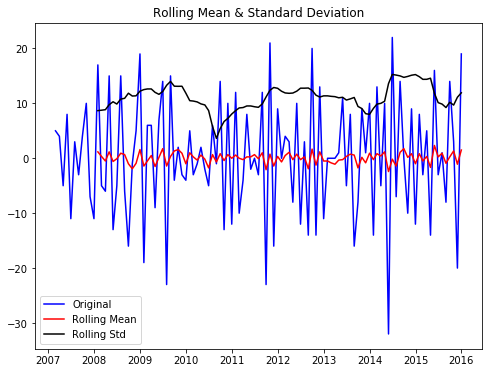

Results of Dickey-Fuller Test:
Test Statistic                 -5.046806
p-value                         0.000018
#Lags Used                     13.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [26]:
# Instantiate East Harlem Seasonal Arima Model
Forecast_Harlem = Seasonal_ARIMA(EastHarlem)

# Test the stationarity of first difference
Forecast_Harlem.first_diff()

# Test the stationarity of the seasonal first difference
Forecast_Harlem.seasonal_first_diff()

Since the rolling mean for the first difference and seasonal first difference are constant we take $d=1$ and $D=1$ with $m=12$ in our seasonal ARIMA model. However, we still need to figure out the values of $p, q, P$ and $Q$.  One way to find the other values is through creating the ACF and PCF plots for the first difference and seasonal first difference.  A good way example of how to do this in Python is the blog post <a href="http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/">here</a>. However, this process is hands on and does not lead towards automating which is necessary for my web application, so I decided to do a grid search for the other seasonal ARIMA paramaters. Using a grid search to find the correct parameter choices can be a time consuming process, so inorder to keep the runtime down I limited the values of these.  There is always a trade off between speed and accuracy and while using the ACF and PCF plots can be more accurate, I had to sacrifice some accuracy for speed and automation.


To find the values for $p, q, P$ and $Q$ using a grid search we'll loop through all the possible values, fit the <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX model</a> to the training data (1/2006 - 12/2014).  We then compute the validation error, by dynamically forecasting crimes in validation year (1/2014 - 12/2014) and the finding the root mean square error in the predicted number of monthly crimes and recorded number of monthly crimes.  We then choose the model paramater values which minimize the validation error. After the model has been again fitted on the training data, we then forecast it for test set year (1/2015 - 12/2015) and find the error between the the predicted values and the record values.  We store the test set error and once again re-train the model, but this time on ALL of the data (1/2006 - 12/2015). 


*Note: We enforce stationarity and invertability of model through the use of a try-except block. The code will try to fit the mdoel using all parameter values and if <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX</a> throws an error when fitting our model, we don't record their values or validation error and move onto the next paramter values.*

We now can fit our model to the data by using the <code>fit()</code> method:

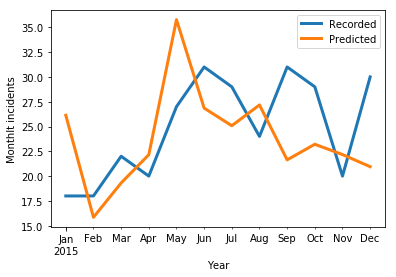

In [27]:
# Fit it to training data. Choose appropriate paramater values
# by doing a grid search and choosing the values with the smallest
# RMSE on the validation set
Forecast_Harlem.fit()

# Plot the dynamic forecast on the validation set
Forecast_Harlem.plot_test()

Using the <code>plot_test()</code> method as we did above we can see how our model's forecast compares to the test set data.  Over all we do fairly well, except in the end of year, our model seems to fail to capture the upswing in the the number of asaults in December.  This could be because of the increase in the trend of assaults in 2015 as mentioned previously. We can see the $[p,d,q,P,D,Q]$ values for our model by typing,

In [28]:
print(Forecast_Harlem.params)

[1, 1, 1, 2, 1, 1]


We can repeat the same procedure for the Midtown larceny data. We will  assume $d=D=1$ in all our models and enforce stationarity through the try-except block:

[0, 1, 0, 1, 1, 1]


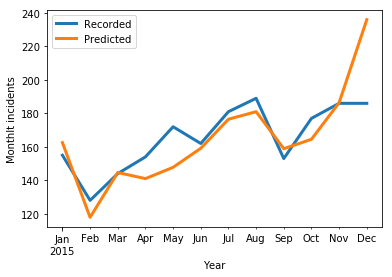

In [29]:
# Instantiate the Midtown Seasonal Arima model object
Forecast_Midtown = Seasonal_ARIMA(Midtown)

# Fit the model to the data
Forecast_Midtown.fit()

# Plot the predicted and recorded data of the test set
Forecast_Midtown.plot_test()
print(Forecast_Midtown.params)

We can see that overall our model does very well on the test set, except it over estimates the number of crimes involving larceny in the month of Decemeber.


We can now forecast our monthly crime rates into the future using the <code>forecast()</code> method and plot them using the <code>plot_forecast()</code> method:

Text(0.5, 1.0, 'Forcaste Monthly Assault Rate In East Harlem')

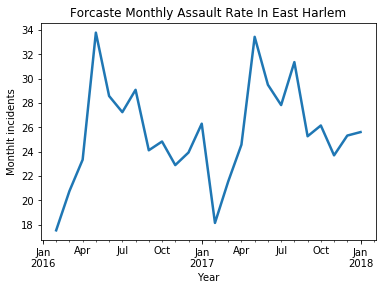

In [30]:
# Forecast two years into the future
Forecast_Harlem.forecast()

# Plot the forecasted crime rates
Forecast_Harlem.plot_forecast()
plt.title("Forcaste Monthly Assault Rate In East Harlem")

Text(0.5, 1.0, 'Forcaste Monthly Larceny Rate In Midtown')

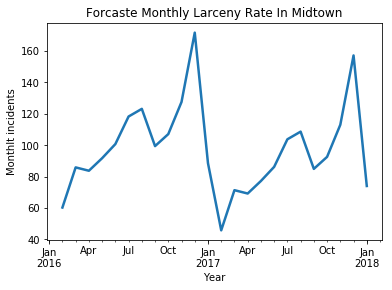

In [31]:
# Forecast two years into the future
Forecast_Midtown.forecast()

# Plot the forecasted crime rates
Forecast_Midtown.plot_forecast()
plt.title("Forcaste Monthly Larceny Rate In Midtown")

----------------
## Conclusion
-----------------

In this post we have looked into using exploratory data analysis to come up with a data driven strategie to reduce crime in Manhattan.  We saw that larceny and assault are two crimes that effect different parts of Manhattan and also peak at different times of the year. Larceny effects midtown and peaks at the end of the year, while assault effects East Harlem and peaks in summer time.  We looked into time series analysis to model monthly crime rates in both Midtown and East Harlem and used them to predict monthly crime rates into the future. This is just an small example with two neighborhoods, but if police are better able to predict monthly crime rates on a neighborhood level they can more effectively distribute their resources at the appropriate place and time. Lastly, I demonstrated how to use the tools I developed; this will be helpful to those trying to extend the codebase of <a href="https://crimetime.online">CrimeTime.online</a>


Hopefully this post has been both ineteresting and informative!